In [ ]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla V100-SXM2-16GB


In [ ]:
df = pd.read_csv('/content/temizlendi_correctyapıldı_stoplarfalan_silinmedi_sadece1kere_gecenler_silindi.csv')

In [ ]:
df = df.rename(columns={'idea': 'Category', 'sentence': 'Message'})
df.head()

,Unnamed: 0,Message,Category
0,1,we are clearly having a abc correction after w...,Short
1,2,we all know etc needs some correction order bl...,Short
2,3,hello traders on the daily time frame the btcu...,Short
3,4,the first day of the week has started with a v...,Short
4,5,a lot of investors are getting optimistic view...,Short


In [ ]:
df.Category.value_counts()

Long     3473
Short    2670
Name: Category, dtype: int64

In [ ]:
df.Category.value_counts(normalize=True)

Long     0.565359
Short    0.434641
Name: Category, dtype: float64

In [ ]:
df_short = df[df['Category']=='Short']
df_long = df[df['Category']=='Long']
df_long_downsampled = df_long.sample(df_short.shape[0])
df= pd.concat([df_long_downsampled, df_short])
df['Category'].value_counts()

Long     2670
Short    2670
Name: Category, dtype: int64

In [ ]:
df= df.reset_index(drop=True)

In [ ]:
df=df.rename(columns={"Message": "text", "Category": "category"})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5340 entries, 0 to 5339
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5340 non-null   int64 
 1   text        5338 non-null   object
 2   category    5340 non-null   object
dtypes: int64(1), object(2)
memory usage: 125.3+ KB


In [ ]:
df=df.dropna()

In [ ]:
df.category.value_counts(normalize=True)

Short    0.500187
Long     0.499813
Name: category, dtype: float64

In [ ]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

In [ ]:
df

,Unnamed: 0,text,category,encoded_categories
0,2333,using ta along with prior uptrends i believe e...,Long,0
1,4861,there is some exciting news to share with you ...,Long,0
2,4638,hi guns i hope you have a fantastic week ahead...,Long,0
3,5507,it took weeks to respect zone may take few mor...,Long,0
4,3749,looks like we will be visiting closer to previ...,Long,0
...,...,...,...,...
5335,6136,hi i see a very good trade opportunity risk to...,Short,1
5336,6137,possible etc rejection there at the h s resist...,Short,1
5337,6140,another close up view maybe i m wrong maybe no...,Short,1
5338,6142,it is expected that the price will change the ...,Short,1


In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
sentences = df.text.values

In [ ]:
max_len=395

In [ ]:

training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

print("Training: ", len(training))
print("Test: ", len(test))

training_texts = training.text.values
training_labels = training.encoded_categories.values

Training:  4270
Test:  1068


In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  strong bluish divergence on etc and a few other crept pairs indicating we re about to return to the high of mio
Token IDs: tensor([  101,  2844, 14154,  4509, 17856, 17905,  2006,  4385,  1998,  1037,
         2261,  2060, 13147,  7689,  8131,  2057,  2128,  2055,  2000,  2709,
         2000,  1996,  2152,  1997,  2771,  2080,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

number_of_categories = len(df['encoded_categories'].unique())

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
epochs = 10

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        output = model(b_input_ids,

                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output['loss']
        logits = output['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 10 ========
Batch    10  of    134.    Elapsed: 0:00:04.
Batch    20  of    134.    Elapsed: 0:00:08.
Batch    30  of    134.    Elapsed: 0:00:11.
Batch    40  of    134.    Elapsed: 0:00:14.
Batch    50  of    134.    Elapsed: 0:00:18.
Batch    60  of    134.    Elapsed: 0:00:21.
Batch    70  of    134.    Elapsed: 0:00:24.
Batch    80  of    134.    Elapsed: 0:00:28.
Batch    90  of    134.    Elapsed: 0:00:31.
Batch   100  of    134.    Elapsed: 0:00:34.
Batch   110  of    134.    Elapsed: 0:00:38.
Batch   120  of    134.    Elapsed: 0:00:41.
Batch   130  of    134.    Elapsed: 0:00:44.
Average training loss: 0.63
Training epoch took: 0:00:45
======== Epoch 2 / 10 ========
Batch    10  of    134.    Elapsed: 0:00:03.
Batch    20  of    134.    Elapsed: 0:00:07.
Batch    30  of    134.    Elapsed: 0:00:10.
Batch    40  of    134.    Elapsed: 0:00:13.
Batch    50  of    134.    Elapsed: 0:00:16.
Batch    60  of    134.    Elapsed: 0:00:20.
Batch    70  of    134.   

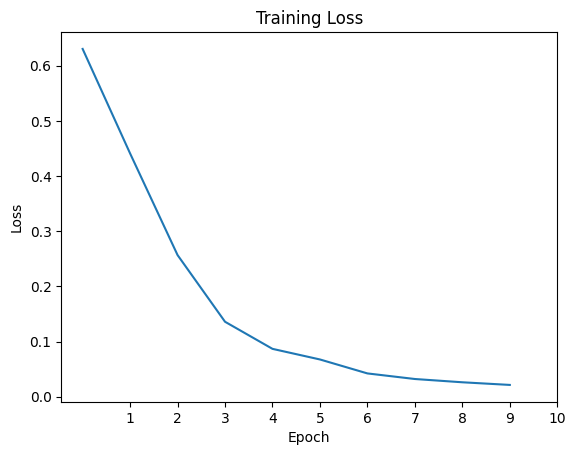

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

In [ ]:

test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [ ]:

f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'long',
                          '1':'short',
                          })

print(report)

F-Score:  0.7836242076929756
Recall:  0.7837078651685393
Precision:  0.7841473051999368
                 long       short  accuracy    macro avg  weighted avg
precision    0.795322    0.772973  0.783708     0.784147      0.784147
recall       0.764045    0.803371  0.783708     0.783708      0.783708
f1-score     0.779370    0.787879  0.783708     0.783624      0.783624
support    534.000000  534.000000  0.783708  1068.000000   1068.000000


In [ ]:
report

,long,short,accuracy,macro avg,weighted avg
precision,0.766187,0.789062,0.777154,0.777625,0.777625
recall,0.797753,0.756554,0.777154,0.777154,0.777154
f1-score,0.781651,0.772467,0.777154,0.777059,0.777059
support,534.000000,534.000000,0.777154,1068.000000,1068.000000
